# Time-Complexity of Isolines Method

Method is very time consuming. This doc lays this bare, and explores ways to make it faster.

In [28]:
# load libraries
library(MASS)
library(ismev)
library(evd)
library(ggplot2)
library(dplyr)
library(mvtnorm)
library(tidyr)
library(parallel)
library(doParallel)
library(foreach)
library(ks)

In [33]:
# load up the R functions from the OG isolines paper
source('/global/u1/j/jbbutler/isolines_uq/scripts/R/orig_isolines.R')

## Function of Sample Size n

Change the sample size of the input data, measure how much time it takes to run the method (with all default settings, including grid size, number of isolines to draw, etc.)

In [5]:
ns <- (1:20)*500
num_times <- 5
times <- matrix(rep(0, length(ns)*num_times), nrow = length(ns))

for (i in 1:length(ns)) {
    
    n_times <- rep(0, num_times)
    
    for (j in 1:num_times) {
        
        dat <- rmvt(ns[i], sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4)
        start <- proc.time()[[1]]
        res <- suppressWarnings(xContours(dat = dat, faster = FALSE))
        n_times[j] <- proc.time()[[1]] - start
        
        }
    
    times[i,] <- n_times    
}


In [7]:
means <- apply(times, 1, mean)
ses <- apply(times, 1, sd)/sqrt(num_times)

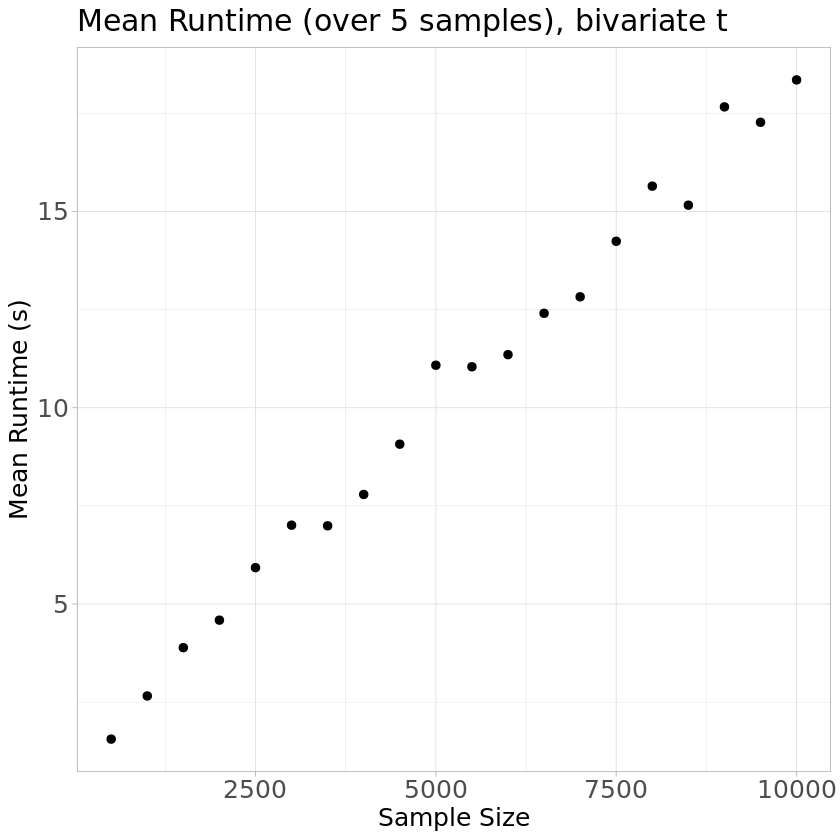

In [8]:
plt_dat <- data.frame(means = means, n = ns)
ggplot(plt_dat) + geom_point(aes(x = ns, y = means), size = 2) + 
ylab('Mean Runtime (s)') + xlab('Sample Size') + ggtitle('Mean Runtime (over 5 samples), bivariate t') +
theme_light() + theme(axis.title = element_text(size = 15), axis.text = element_text(size = 15), text = element_text(size = 15)) 




They use sample sizes close to 10000 (both in toy problems and in applications), so each iteration would take about 15 seconds. 100 bootstrap iterations for 100 data simulations for a single sample size would take a little less than 2 days to run. To do a coverage analysis of the bootstrap confidence intervals, this is less than ideal (without sacrificing bootstrap sample sizes/number of simulations, which might render our CIs/coverage rates useless)

### With Faster CDF Estimation

In [34]:
ns <- (1:20)*500
num_times <- 5
times <- matrix(rep(0, length(ns)*num_times), nrow = length(ns))

for (i in 1:length(ns)) {
    
    n_times <- rep(0, num_times)
    
    for (j in 1:num_times) {
        
        dat <- rmvt(ns[i], sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4)
        start <- proc.time()[[1]]
        res <- xContours(dat = dat, faster = TRUE)
        n_times[j] <- proc.time()[[1]] - start
        
        }
    
    times[i,] <- n_times    
}

In [35]:
means <- apply(times, 1, mean)
ses <- apply(times, 1, sd)/sqrt(num_times)

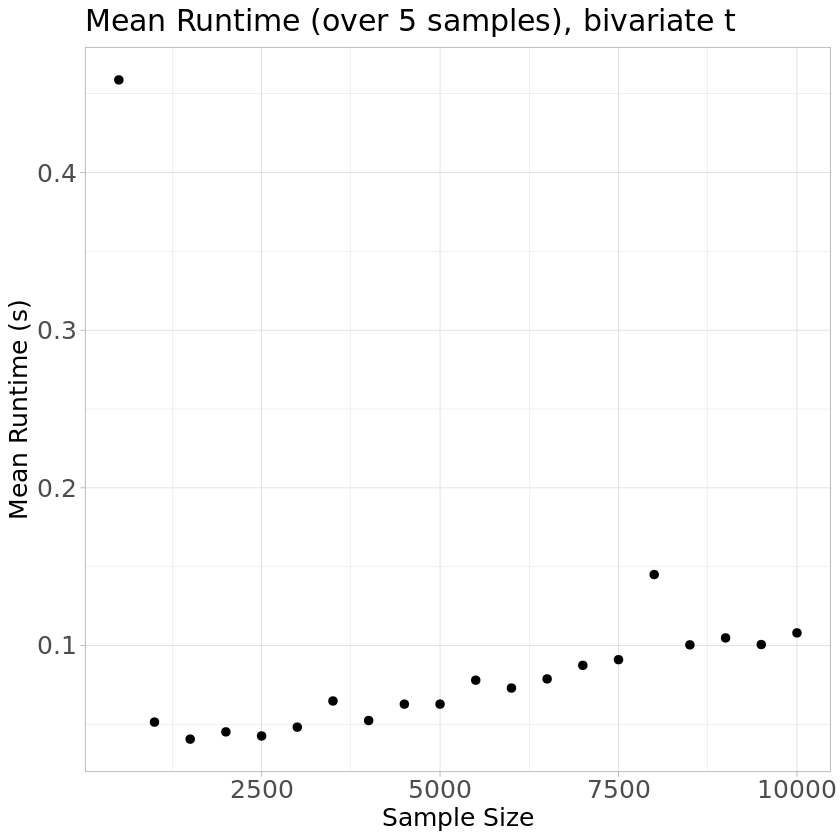

In [5]:
plt_dat <- data.frame(means = means, n = ns)
ggplot(plt_dat) + geom_point(aes(x = ns, y = means), size = 2) + 
ylab('Mean Runtime (s)') + xlab('Sample Size') + ggtitle('Mean Runtime (over 5 samples), bivariate t') +
theme_light() + theme(axis.title = element_text(size = 15), axis.text = element_text(size = 15), text = element_text(size = 15)) 

## Computational Bottlenecks

Already made a plot using the old way of estimating the CDFs (non FFT-based), now we make a plot showing possible areas of computational bottlenecks with the FFT-based CDF estimation.

In [37]:
ns <- (1:20)*500
num_reps <- 10
num_chunks <- 6

times_log <- vector(mode = 'list', length = length(ns))

for (i in 1:length(ns)) {
    
    n_times <- matrix(rep(0, num_reps*num_chunks), nrow = num_chunks)
    
    for (j in 1:num_reps) {
        
        dat <- rmvt(ns[i], sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4)
        res <- suppressWarnings(xContours(dat = dat, faster = TRUE))
        n_times[1 ,j] <- res$elapsed_proj
        n_times[2 ,j] <- res$elapsed_contour
        n_times[3, j] <- res$elapsed_cdfest
        n_times[4, j] <- res$elapsed_martrans
        n_times[5, j] <- res$elapsed_gpdfit
        n_times[6, j] <- res$elapsed_cbinding
        
        }
    
    times_log[[i]] <- n_times    
}

In [38]:
avg_times <- matrix(rep(0, length(ns)*num_chunks), ncol = num_chunks)

for (i in 1:length(ns)) {
 
    avg_times[i,] <- apply(times_log[[i]], 1, mean)
    
}

plt_df <- data.frame(cbind((1:length(ns))*500, avg_times))
colnames(plt_df) <- c('n', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6')

In [39]:
plt_df_long <- gather(plt_df, key = 'chunk', value = 'time', X1:X6)

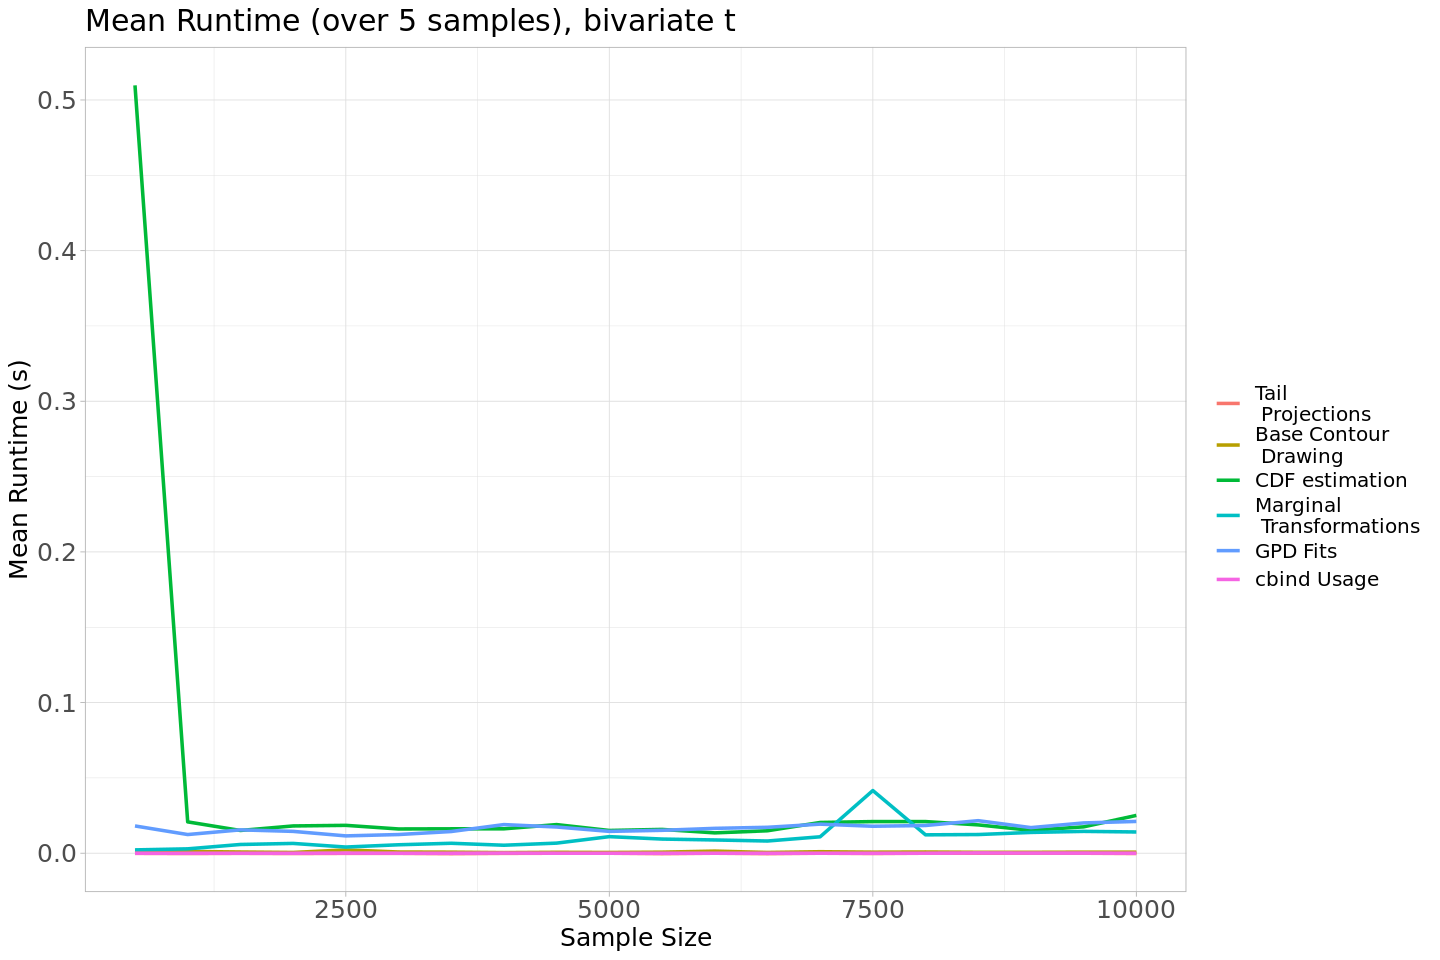

In [40]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(plt_df_long) + 
geom_line(aes(x = n, y = time, color = chunk), size = 1) +
ggtitle('Runtime of Various Code Chunks (5-run avg.)') +
scale_color_discrete(name = '', breaks = c('X1', 'X2', 'X3', 'X4', 'X5', 'X6'), labels = c('Tail \n Projections', 'Base Contour \n Drawing', 'CDF estimation', 'Marginal \n Transformations', 'GPD Fits', 'cbind Usage')) +
ylab('Mean Runtime (s)') + xlab('Sample Size') + ggtitle('Mean Runtime (over 5 samples), bivariate t') +
theme_light() + theme(axis.title = element_text(size = 15), axis.text = element_text(size = 15), text = element_text(size = 15)) 



Seems like the usage of cbind is an issue, will see if I can rectify this

In [48]:
a <- rep(10, 150)
b <- rep(10, 150)

start <- proc.time()
c <- cbind(a, b)
proc.time() - start

   user  system elapsed 
  0.003   0.000   0.004 

## Attempts to Make it Faster

### 1. Parallelization of the CDF estimation

In [19]:
detectCores()

[1] 64

In [22]:
n_cores <- 32
ns <- (1:20)*500
num_reps <- 5
gridSize <- 100

cdf_timelog <- matrix(rep(0, length(ns)*num_reps), ncol = length(ns))

for (i in 1:length(ns)) {
    for (j in 1:num_reps) {
        
        dat <- rmvt(ns[i], sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4)
        xGrid <- seq(min(dat[,1]), max(dat[,1]), l = gridSize)
        yGrid <- seq(min(dat[,2]), max(dat[,2]), l = gridSize)
        grid <- expand.grid(xGrid, yGrid)
        bw <- c(bandwidth.nrd(dat[,1]), bandwidth.nrd(dat[,2]))
        start <- proc.time()[[1]]
        clust <- makeCluster(n_cores)
        surv <- parApply(clust, grid, 1, kernSurv, dat = dat, bw = bw)
        stopCluster(clust)
        cdf_timelog[j, i] <- proc.time()[[1]] - start
        
    }
}


Know that it's generally better to parallelize outer loops as opposed to inner loops, and parallelizing the cdf estimation is as inner as it gets. So, I'll try to parallelize the bootstrap code instead.

### 2. Parallelization of Sample Loops

In [40]:
ns <- c(500)
n_boot_samps <- 5
n_samps <- 5

In [41]:
boot_outs_ns <- vector(mode = 'list', length = length(ns))

for (i in 1:length(ns)) {

    boot_out_n_samps <- vector(mode = 'list', length = n_samps)
    
    start <- proc.time()

    print(paste('Starting n:', i))

    for (j in 1:n_samps) {

        boot_out_n_samp <- list()
        t_dat <- data.frame(rmvt(ns[i], sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        boot_out_n_samp$data <- t_dat

        boot_samps <- vector(mode = 'list', length = n_boot_samps)

        for (k in 1:n_boot_samps) {
            boot_out <- list()
            boot_dat <- t_dat %>% sample_frac(1, replace = TRUE)
            boot_out_full <- suppressWarnings(xContours(dat = boot_dat))
            boot_out$boot_out_isolines <- c(list(boot_out_full$contourOrig), boot_out_full$projContours)
            boot_out$boot_out_dat <- boot_dat
            boot_out$boot_out_levels <- c(boot_out_full$setup$baseContourLevel, boot_out_full$setup$projContourLevels)

            boot_samps[[k]] <- boot_out

        }

        print(paste('samp:', j))

        boot_out_n_samp$bootstrap_info <- boot_samps

        boot_out_n_samps[[j]] <- boot_out_n_samp

    }

    print(paste('Finished n:', i))

    boot_outs_ns[[i]] <- boot_out_n_samps
    
    elapsed <- proc.time() - start

}


[1] "Starting n: 1"
[1] "samp: 1"
[1] "samp: 2"
[1] "samp: 3"
[1] "samp: 4"
[1] "samp: 5"
[1] "Finished n: 1"


In [42]:
elapsed

   user  system elapsed 
 47.877   2.048  46.935 

In [81]:
n_cores <- 5

boot_outs_ns <- vector(mode = 'list', length = length(ns))

for (i in 1:length(ns)) {
    
    start <- proc.time()

    print(paste('Starting n:', i))
    clust <- makeCluster(n_cores)
    registerDoParallel(cl = clust)
    boot_out_n_samps <- foreach(j = 1:n_samps, .packages = c('mvtnorm', 'dplyr', 'MASS', 'ismev', 'evd')) %dopar% {

        boot_out_n_samp <- list()
        t_dat <- data.frame(rmvt(ns[i], sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        boot_out_n_samp$data <- t_dat

        boot_samps <- vector(mode = 'list', length = n_boot_samps)

        for (k in 1:n_boot_samps) {
            boot_out <- list()
            boot_dat <- t_dat %>% sample_frac(1, replace = TRUE)
            boot_out_full <- suppressWarnings(xContours(dat = boot_dat))
            boot_out$boot_out_isolines <- c(list(boot_out_full$contourOrig), boot_out_full$projContours)
            boot_out$boot_out_dat <- boot_dat
            boot_out$boot_out_levels <- c(boot_out_full$setup$baseContourLevel, boot_out_full$setup$projContourLevels)

            boot_samps[[k]] <- boot_out

        }

        boot_out_n_samp$bootstrap_info <- boot_samps

    }
    
    stopCluster(clust)

    print(paste('Finished n:', i))

    boot_outs_ns[[i]] <- boot_out_n_samps
    
    elapsed <- proc.time() - start

}


[1] "Starting n: 1"
[1] "Finished n: 1"


In [85]:
elapsed

   user  system elapsed 
  0.170   0.061  13.945 

About 3 times faster. I'll try to implement a parallelization of this loop in the code I'm running, hopefully won't take too long

### 3. FFT for Gaussian Kernel CDF Estimation

In [164]:
n <- 10000
t_dat <- rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4)

In [165]:
# get bandwidth
bw <- c(bandwidth.nrd(dat[,1]), bandwidth.nrd(dat[,2]))
H <- (diag(bw)/4)^2


In [166]:
res <- kcde(dat, H = H, gridsize = 100, tail.flag = 'upper')
Z <- as.vector(res$estimate)
X <- as.vector(res$eval.points[[1]])
Y <- as.vector(res$eval.points[[2]])
grid1 <- expand.grid(X, Y)
plt_dat <- data.frame(X = grid1[,1], Y = grid1[,2], Z = as.vector(Z))

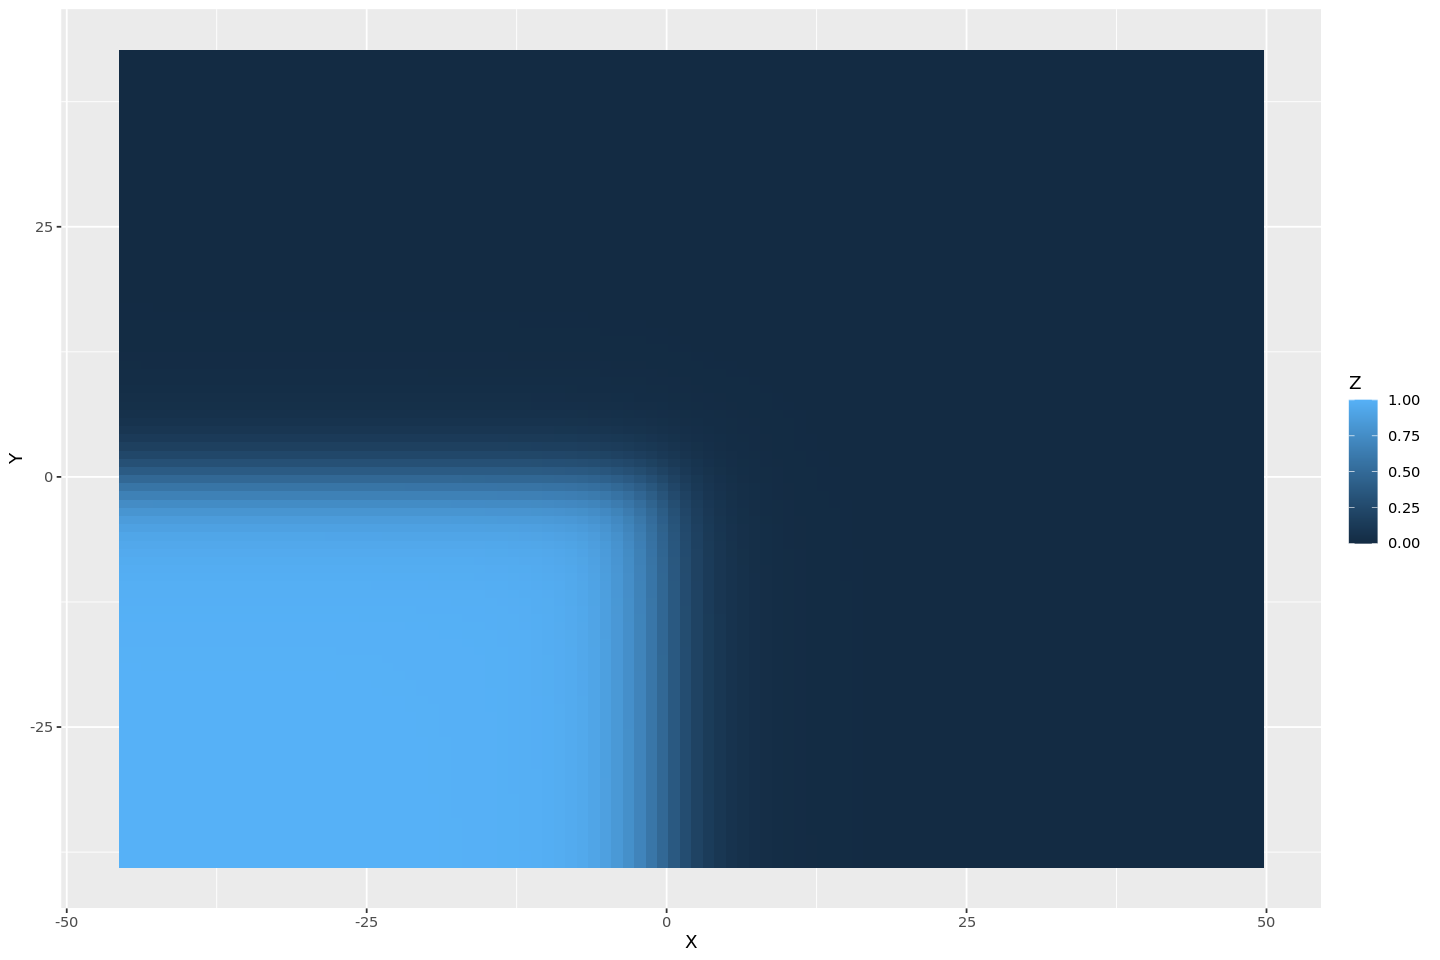

In [167]:
ggplot(plt_dat) + geom_tile(aes(x = X, y = Y, fill = Z))



In [168]:
gridSize <- 100

xGrid <- seq(min(dat[,1]), max(dat[,1]), l = gridSize)
yGrid <- seq(min(dat[,2]), max(dat[,2]), l = gridSize)
grid2 <- expand.grid(xGrid, yGrid)
surv <- apply(grid2, 1, kernSurv, dat = dat, bw = bw)

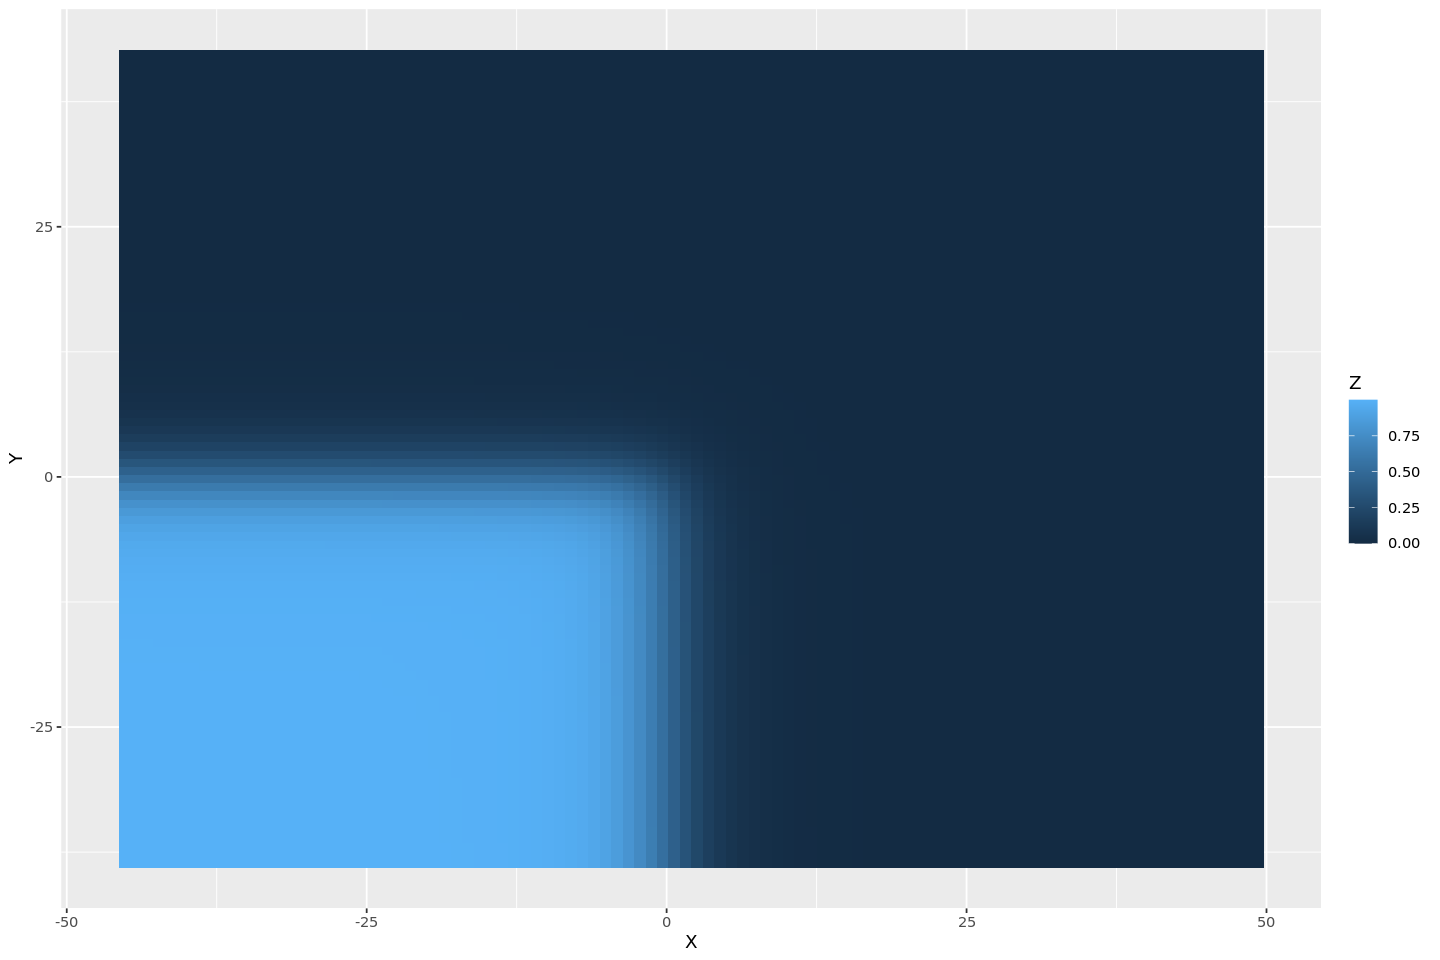

In [160]:
plt_dat <- data.frame(X = grid2[,1], Y = grid2[,2], Z = surv)
ggplot(plt_dat) + geom_tile(aes(x = X, y = Y, fill = Z))

For all intents and purposes, they are both the same survival functions, but one is MUCH faster than the other. Now, let's try to actually run the algorithm with these.

### Slower Method

In [132]:
t_out <- xContours(dat = t_dat)
base_dat <- data.frame(t_out$contourOrig)
proj1_dat <- data.frame(t_out$projContours[[1]])
proj2_dat <- data.frame(t_out$projContours[[2]])
proj3_dat <- data.frame(t_out$projContours[[3]])

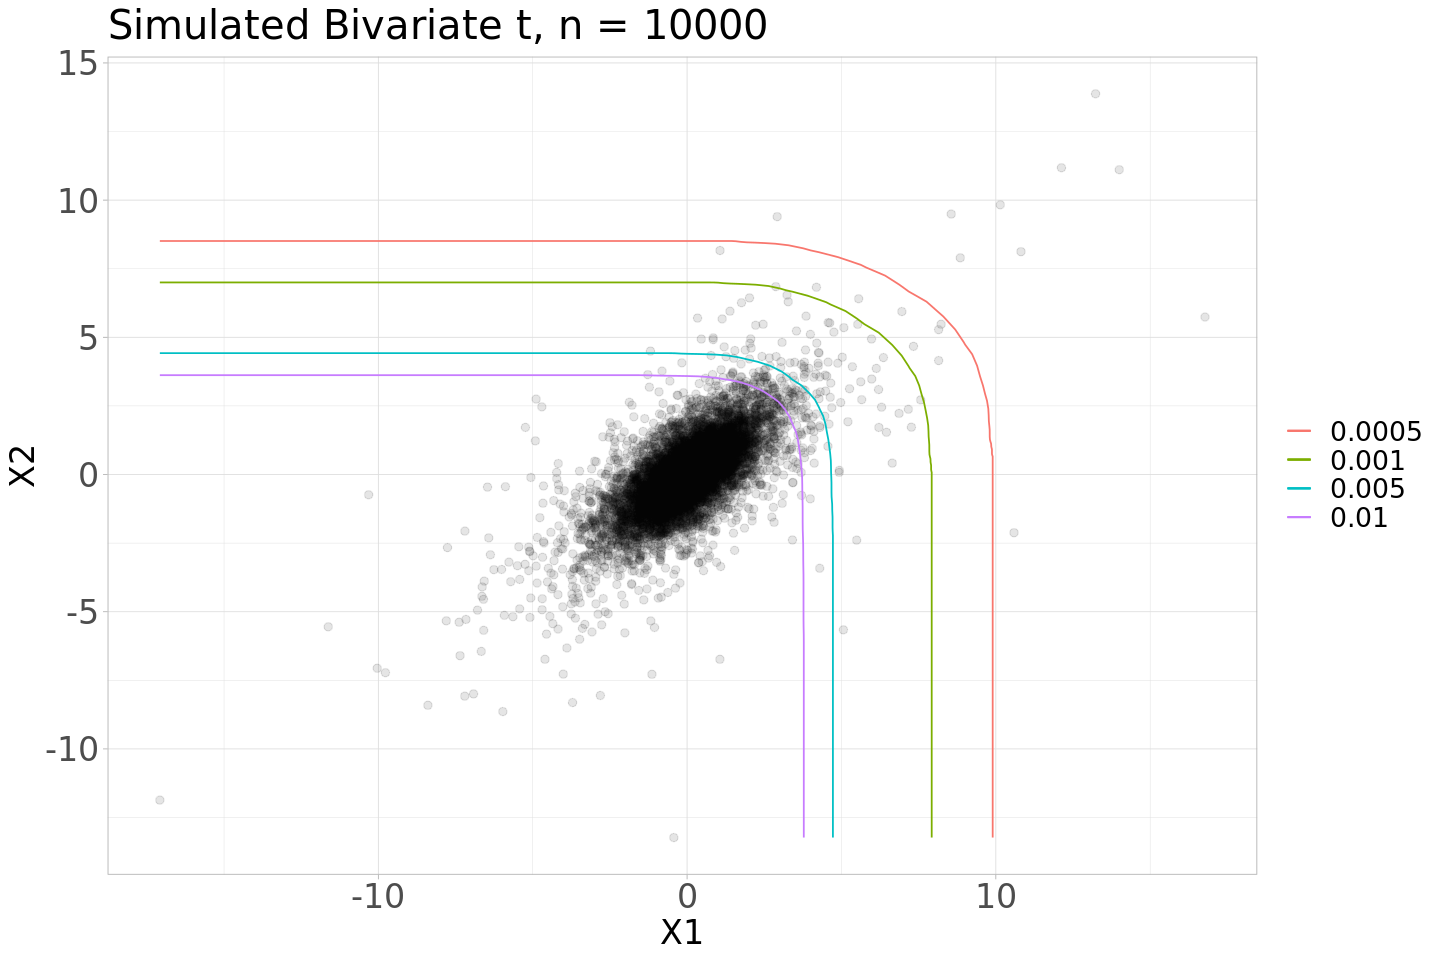

In [128]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot() + geom_point(data = data.frame(t_out$data), aes(x = X1, y = X2), alpha = 0.1, size = 2) + 
geom_line(data = base_dat, aes(x = X1, y = X2, color = '0.01')) + 
geom_line(data = proj1_dat, aes(x = X1, y = X2, color = '0.005')) + 
geom_line(data = proj2_dat, aes(x = X1, y = X2, color = '0.001')) + 
geom_line(data = proj3_dat, aes(x = X1, y = X2, color = '0.0005')) + 
ggtitle(paste('Simulated Bivariate t, n =', n)) + theme_light() + 
theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20), legend.title = element_blank())


### Faster Method

In [130]:
t_out <- xContours(dat = t_dat, faster = TRUE)
base_dat <- data.frame(t_out$contourOrig)
proj1_dat <- data.frame(t_out$projContours[[1]])
proj2_dat <- data.frame(t_out$projContours[[2]])
proj3_dat <- data.frame(t_out$projContours[[3]])

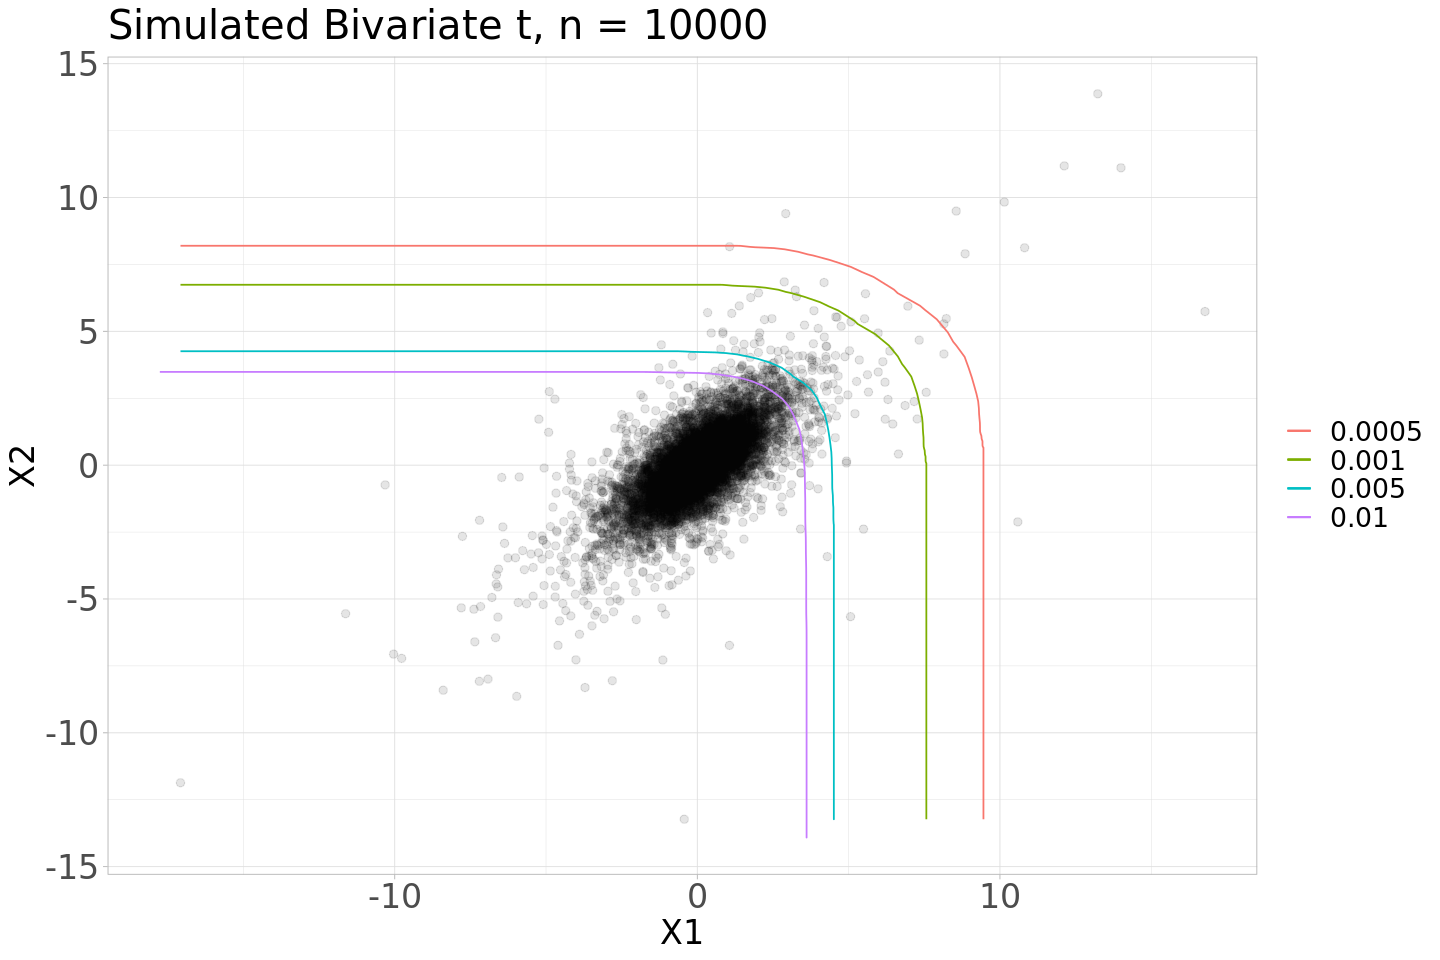

In [131]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot() + geom_point(data = data.frame(t_out$data), aes(x = X1, y = X2), alpha = 0.1, size = 2) + 
geom_line(data = base_dat, aes(x = X1, y = X2, color = '0.01')) + 
geom_line(data = proj1_dat, aes(x = X1, y = X2, color = '0.005')) + 
geom_line(data = proj2_dat, aes(x = X1, y = X2, color = '0.001')) + 
geom_line(data = proj3_dat, aes(x = X1, y = X2, color = '0.0005')) + 
ggtitle(paste('Simulated Bivariate t, n =', n)) + theme_light() + 
theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20), legend.title = element_blank())


Why are the isolines slightly different? Not sure what to do about this.. Check to see if you'd expect the survival functions to be different.. Just in case it's an issue with the bandwidth, you could experiment with doing a different bandwidth matrix now that you don't have to assume independence anymore..

### Time Difference Between Asymptotic Dependence/Independence

#### Old CDF Estimation Technique

In [32]:
num_reps <- 20
times_dep <- rep(0, num_reps)
times_indep <- rep(0, num_reps)
n_samp <- 1000

for (i in 1:num_reps) {
    start <- proc.time()[[1]]
    t_dat <- rmvt(n_samp, sigma = matrix(c(1,0.7,0.7,1), nrow = 2), df = 4)
    suppressWarnings(xContours(dat = t_dat, faster = FALSE))
    times_dep[i] <- proc.time()[[1]] - start
    
    start <- proc.time()[[1]]
    gauss_dat <- rmvnorm(n_samp, mean = rep(0, 2), sigma = matrix(c(1,0.7,0.7,1), nrow = 2))
    suppressWarnings(xContours(dat = t_dat, faster = FALSE, asympIndep = TRUE))
    times_indep[i] <- proc.time()[[1]] - start
}



In [33]:
res <- data.frame(indep = times_indep, dep = times_dep)
round(colMeans(res), 3)

indep   dep 
2.412 2.428

#### New CDF Estimation Technique

In [36]:
num_reps <- 20
times_dep <- rep(0, num_reps)
times_indep <- rep(0, num_reps)
n_samp <- 1000

for (i in 1:num_reps) {
    start <- proc.time()[[1]]
    t_dat <- rmvt(n_samp, sigma = matrix(c(1,0.7,0.7,1), nrow = 2), df = 4)
    suppressWarnings(xContours(dat = t_dat, faster = TRUE))
    times_dep[i] <- proc.time()[[1]] - start
    
    start <- proc.time()[[1]]
    gauss_dat <- rmvnorm(n_samp, mean = rep(0, 2), sigma = matrix(c(1,0.7,0.7,1), nrow = 2))
    suppressWarnings(xContours(dat = t_dat, faster = TRUE, asympIndep = TRUE))
    times_indep[i] <- proc.time()[[1]] - start
}

In [37]:
res <- data.frame(indep = times_indep, dep = times_dep)
round(colMeans(res), 3)

indep   dep 
0.037 0.032

New CDF estimation technique is a lot faster!